In [1]:
# Code to predict Rayleigh wave amplitude using deep neural networks
# Uses Earthquakes from O1,O2 period 
# Nikhil Mukund (nikhil@iucaa.in, nikhil.mukund@LIGO.ORG)
# Aug 15 2017

from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import losses


Using TensorFlow backend.


In [2]:
filename = '/home/mcoughlin/Seismon/Predictions/L1O1O2_CMT/earthquakes.txt' 

'''
1: earthquake gps time
2: earthquake mag
3: p gps time
4: s gps time
5: r (2 km/s)
6: r (3.5 km/s)
7: r (5 km/s)
8: predicted ground motion (m/s)
9: lower bounding time
10: upper bounding time
11: latitude
12: longitude
13: distance
14: depth (m)
15: azimuth (deg)
16: nodalPlane1_strike
17: nodalPlane1_rake
18: nodalPlane1_dip
19: momentTensor_Mrt
20: momentTensor_Mtp
21: momentTensor_Mrp
22: momentTensor_Mtt
23: momentTensor_Mrr
24: momentTensor_Mpp
25: peak ground velocity gps time
26: peak ground velocity (m/s)
27: peak ground acceleration gps time
28: peak ground acceleration (m/s^2)
29: peak ground displacement gps time
30: peak ground displacement (m)
31: Lockloss time
32: Detector Status
'''

data = pd.read_csv(filename,delimiter=' ',header=None)


Rf_Amp_thresh = 1e-6; 
index = data[25] > Rf_Amp_thresh

data = data[:][index]

In [3]:
# Select features
FeatSet_index = [1,10,7,11,12,13,14,15,16,17,18,19,20,21,22,23]
Target_index = [25]


# Artificially increase samples
data_temp = data
copy_num = 15
noise_level = 1e-2

for i in range(copy_num):
    data_temp = data_temp.append(data_temp)

data_temp[FeatSet_index]  = data_temp[FeatSet_index][:]+np.std(data_temp[FeatSet_index][:])*noise_level 
data = data_temp

data_unscaled = data
X_us = np.asarray(data[FeatSet_index])
Y_us = np.asarray(data[Target_index])
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(X_us, Y_us, test_size=0.2,random_state=42)
x_train_us, x_val_us, y_train_us, y_val_us = train_test_split(x_train_us, y_train_us, test_size=0.4,random_state=42)

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

X = np.asarray(data[FeatSet_index])
Y = np.asarray(data[Target_index])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4,random_state=42)

In [10]:
#############################################
# Construct the neural network and train it #
#############################################

inp_layer = x_train.shape[1]
dense_layers = 9
dense_activation = 'elu'
optimizer = 'adam'
loss = 'mse'
batch_size = 100000
Nepoch = 10
verbose = 1
Nbatch = 100

# define the network topology  -- -- -- - - -  -  -   -   -    -  
model = Sequential()
model.add(Dense(inp_layer, input_shape=(inp_layer,), activation = 'linear'))

# this layer increases trainging time but seems to not increase performance
model.add(Dense(inp_layer, activation = 'elu'))
#model.add(Dense(Nang+Nspot, activation = 'elu'))  # try one more fully connected 

g = range( dense_layers ) # add layers; decrease size of each by half 
g.reverse()     
for k in g[0:-2]:
    model.add(Dense(2**k, activation = dense_activation))
    #model.add(Dropout(0.3))

model.add(Dense(1,    activation = 'linear'))
                                
model.compile(optimizer=optimizer, loss=loss) 

In [11]:
model.fit(x_train, y_train,
                   validation_data = (x_val,y_val),
                   batch_size      = Nbatch,
                   epochs          = Nepoch,
                   verbose         = verbose)   

y_pred = model.predict(x_test)

Train on 2485125 samples, validate on 1656750 samples
Epoch 1/10
2485125/2485125 [==============================] - 58s - loss: 1.6982e-04 - val_loss: 2.0829e-06
Epoch 2/10
2485125/2485125 [==============================] - 58s - loss: 2.0069e-05 - val_loss: 6.4873e-07
Epoch 3/10
2485125/2485125 [==============================] - 57s - loss: 2.7974e-05 - val_loss: 1.2363e-05
Epoch 4/10
2485125/2485125 [==============================] - 57s - loss: 9.1211e-06 - val_loss: 1.2870e-06
Epoch 5/10
2485125/2485125 [==============================] - 58s - loss: 1.0281e-04 - val_loss: 9.9950e-07
Epoch 6/10
2485125/2485125 [==============================] - 57s - loss: 8.4664e-06 - val_loss: 6.1919e-07
Epoch 7/10
2485125/2485125 [==============================] - 57s - loss: 3.2904e-06 - val_loss: 1.1799e-07
Epoch 8/10
2485125/2485125 [==============================] - 57s - loss: 5.4861e-07 - val_loss: 5.0235e-07
Epoch 9/10
2485125/2485125 [==============================] - 57s - loss: 1.1919e-

Percentage captured within a factor of 2 = 96.20


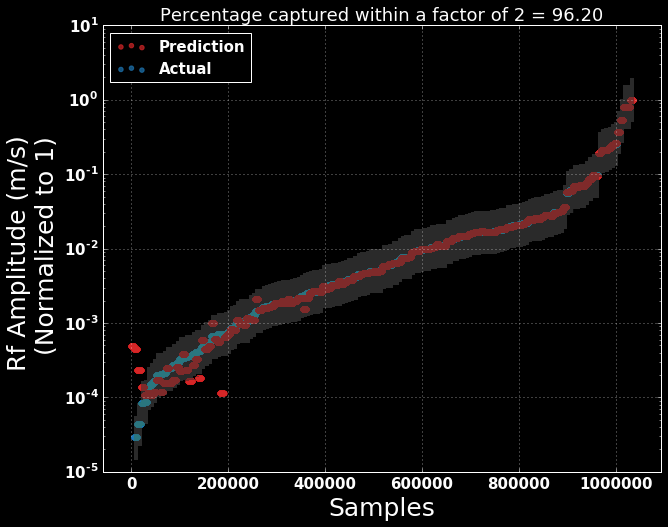

In [12]:
# Rescale back to original 
#y_test = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
#y_pred = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 2
IDX = y_pred/y_test >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))



# sort results in Ascending order
y_test_sort = np.sort(y_test,axis=0)
y_pred_sort = y_pred[np.argsort(y_test,axis=0)]



# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(10,8))

plt.style.use('dark_background')

errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.01 ,color='#7f7f7f')
actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.7)


idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='#d62728',alpha=0.7)         

plt.yscale('log')
plt.grid()
#plt.ylim([1e-7, 1e-3])
plt.ylabel('Rf Amplitude (m/s) \n (Normalized to 1)',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
plt.legend([pred_plt,actual_plt],['Prediction', 'Actual'],loc=2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle=':')
plt.savefig('DNN_Rfamp.png',bbox_inches='tight')

Percentage captured within a factor of 2 = 96.20


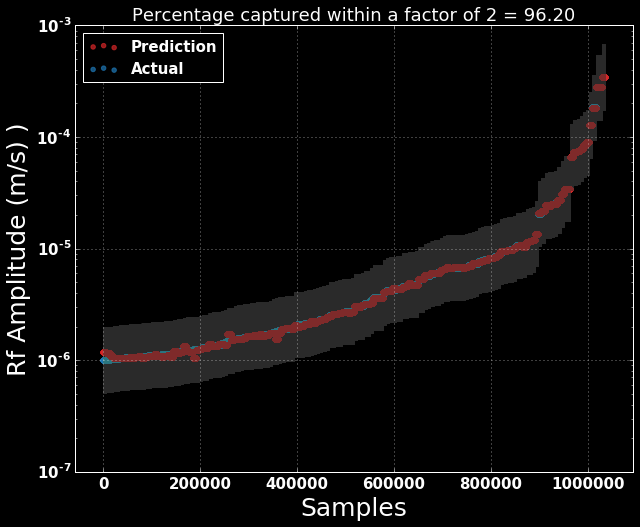

In [16]:

# Rescale back to original 
data_origScale= min_max_scaler.inverse_transform(data)
data_origScale = pd.DataFrame(data_origScale)

y_test_rescaled = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
y_pred_rescaled = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 2
IDX = y_pred_rescaled/y_test_rescaled >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))

# sort results in Ascending order
y_test_sort = np.sort(y_test_us,axis=0)
y_pred_sort = y_pred_rescaled[np.argsort(y_test_us,axis=0)]



# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort





font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})
plt.figure(figsize=(10,8))
plt.style.use('dark_background')

idx = np.arange(0,len(y_test_sort))
errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.01 ,color='#7f7f7f')
actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.7)
idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='#d62728',alpha=0.7)         

plt.yscale('log')
plt.grid()
#plt.ylim([1e-7, 1e-3])
plt.ylabel('Rf Amplitude (m/s) )',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
plt.legend([pred_plt,actual_plt],['Prediction', 'Actual'],loc=2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle=':')
plt.savefig('DNN_Rfamp_rescaled.png',bbox_inches='tight')